In [28]:
%matplotlib inline

import copy
import random
import string

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.stats as stats
import gensim
import networkx
from sklearn import preprocessing

In [2]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'

In [3]:
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [4]:
def connected_word_list(seed_word, keyed_vectors, n_iterations=5):
    all_words = [seed_word]
    for i in range(n_iterations):
        seed_word = random.sample(all_words, 1)
        nearest_neighbors = list(np.array(keyed_vectors.most_similar(seed_word))[:, 0])
        all_words += nearest_neighbors
    return all_words

In [948]:
def semantic_dsm(word_list, keyed_vectors):
    vectors = np.array([keyed_vectors.word_vec(word) for word in word_list])
    dsm = np.clip(dist.pdist(vectors, metric='cosine'), 0, 1)
    return dsm

In [949]:
def semantic_dsm_safe(word_list, keyed_vectors):
    vectors = []
    labels = []
    for word in word_list:
        try:
            vectors.append(keyed_vectors.word_vec(word))
            labels.append(word)
        except:
            pass
    vectors = np.array(vectors)
    matrix = dist.pdist(vectors, metric='cosine')
    return (matrix, labels)

In [950]:
def plot_labeled_matrix(matrix, labels=None):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(10,10))
        plt.imshow(
            matrix, 
            cmap='viridis', 
            vmin=0., 
            vmax=1.
        )
        if labels is not None:
            ax.set_yticklabels(labels)
            ax.set_yticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=90)
            ax.set_xticks(range(len(labels)))
        plt.colorbar()

In [951]:
def make_probability_distribution(v):
    return v / np.sum(v)

In [1086]:
def xcal_like(x, t1=.05, t2=.125, t3=.2, min_adjust=-.05, max_adjust=.05):
    """Given an activation strength, return how to adjust the association strength."""
    xp = [0, t1, t2, t3, 1]
    fp = [0, 0, min_adjust, 0, max_adjust]
    return np.interp(x, xp, fp, left=0, right=max_adjust)

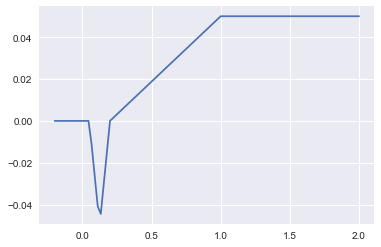

In [1087]:
xs = np.linspace(-.2, 2, 100)
plt.plot(xs, xcal_like(xs))

In [1088]:
class SemanticGraph(object):
    def __init__(self, adj=None, labels=None, word_dsm=None):
        if word_dsm is None:
            self.adj = adj
        else:
            assert word_dsm.shape[0] == word_dsm.shape[1]
            word_adj = 1 - word_dsm
            np.fill_diagonal(word_adj, 0)
            self.adj = word_adj
        self.labels = labels
        
    def query(self, word):
        """Given a word or word index, return a randomly selected connected node.
        The probability distribution for the selection is derived from the adjacency matrix.        
        Like a word association task. A winner-take-all query with no spreading activation (i.e., depth=1).
        """
        if type(word) is int:
            word_i = word
        elif type(word) is str:
            word_i = self.labels.index(word)
        else:
            raise TypeError("word must be str or int (for a word index)")
        
        probs = self.adj[word_i]
        distrib = stats.rv_discrete(values=(range(len(probs)), probs))
        return_ix = distrib.rvs(size=1)[0]
        return_word = self.labels[return_ix]
        
        self.modify_edge(word, return_word, strength=.01)
        
        return (return_word, return_ix)
    
    def activate(self, word_from, strength=1.0, decay=1.0, lower_threshold=.05, new_adj=None, debug=False):
        """Spread activation through the network, adjusting synaptic weights."""
        if debug:
            print("{0} at strength {1}".format(word_from, strength))

        if new_adj is None:
            new_adj = copy.copy(self.adj)
        
        word_from_i = self.labels.index(word_from)
        next_layer_activations = new_adj[word_from_i] * strength * decay
        if debug:
            print(next_layer_activations.round(2))
        
        # Prevent loops by zeroing out weights back to already-activated nodes
        new_adj[:, word_from_i] = 0
        new_adj[:, np.array(next_layer_activations) > lower_threshold] = 0
        #print(new_adj)

        for word_to_i, activation in enumerate(next_layer_activations):
            # Update edge weights
            word_to = self.labels[word_to_i]
            change = xcal_like(activation)
            if debug:
                print("Updating edge: {0} -> {1}, + {2}".format(word_from, word_to, change))
            self.adj[word_from_i, word_to_i] += change
            if self.adj[word_from_i, word_to_i] > 1:
                self.adj[word_from_i, word_to_i] = 1
            if self.adj[word_from_i, word_to_i] < 0:
                self.adj[word_from_i, word_to_i] = 0
            
            if activation > lower_threshold:
                self.activate(self.labels[word_to_i], strength=activation, new_adj=copy.copy(new_adj), debug=debug)

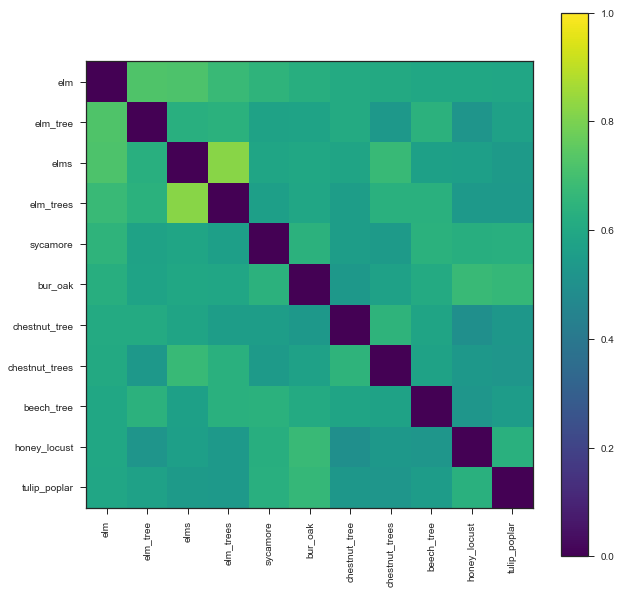

In [1004]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

## Spreading activation and weight updating

### Activating one word over and over again

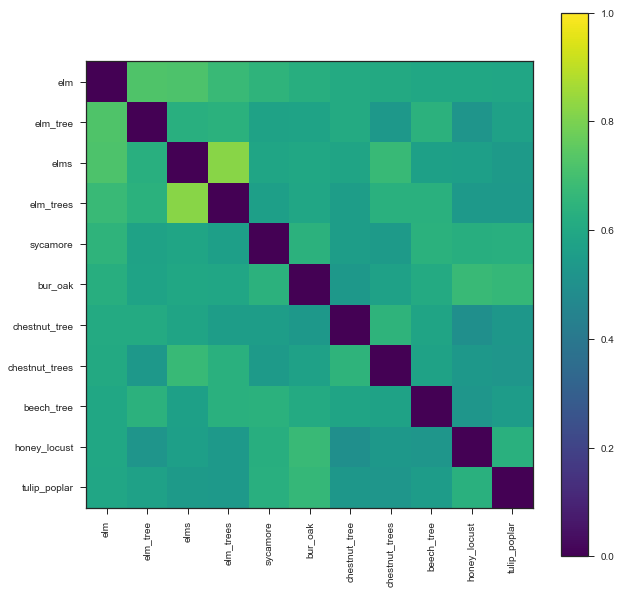

In [1005]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [1006]:
for i in range(20):
    g.activate('elm')

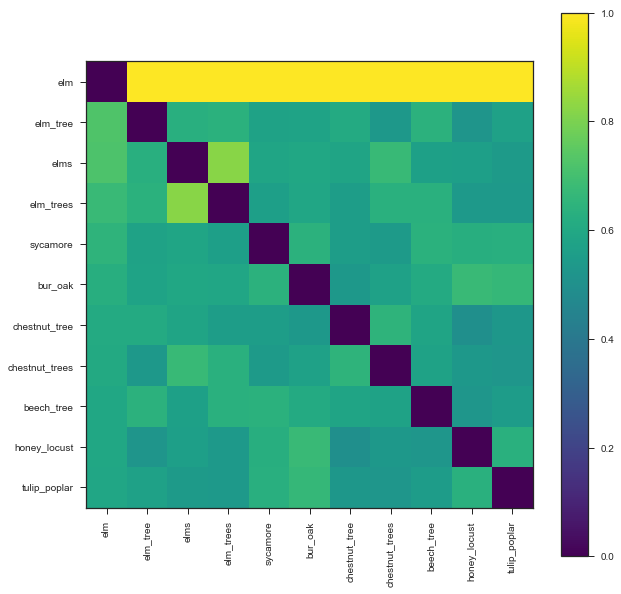

In [1007]:
plot_labeled_matrix(g.adj, g.labels)

### Activating random words

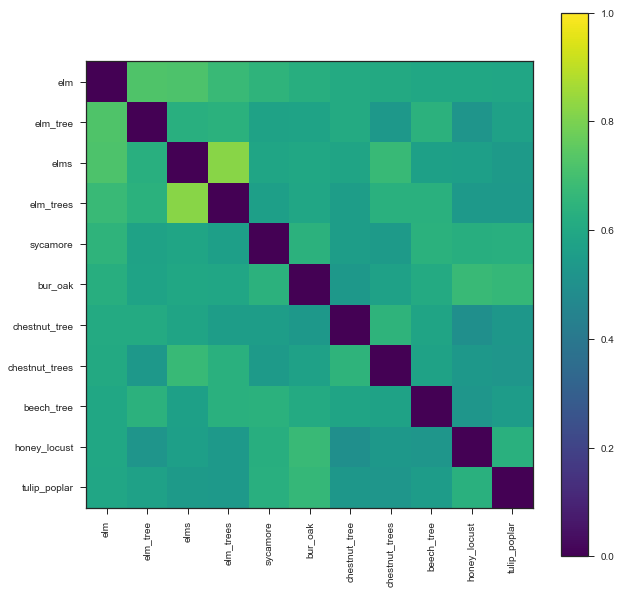

In [1008]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [1009]:
for i in range(200):
    g.activate(np.random.choice(g.labels, 1)[0])

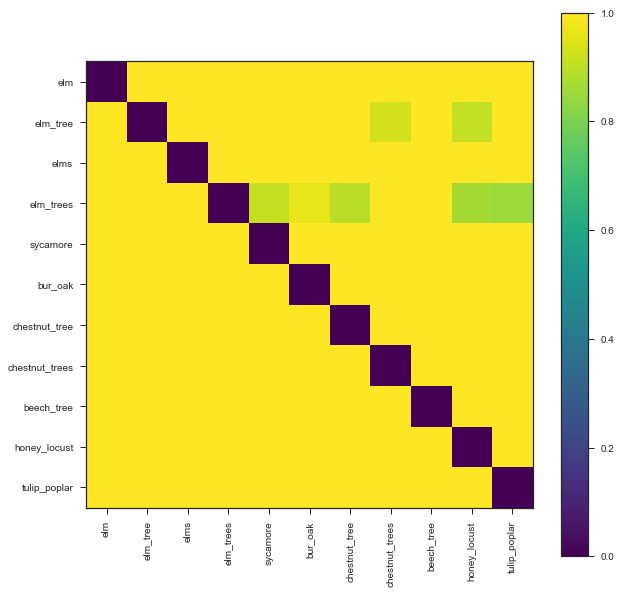

In [1010]:
plot_labeled_matrix(g.adj, g.labels)

## Simulating previous work

### Goodmon & Anderson (2011), experiment 1

In [1103]:
animal_pairs = [
    ('lion', 'tiger'), 
    ('horse', 'pony'), 
    ('walrus', 'seal'), 
    ('duck', 'goose')
]

profession_pairs = [
    ('lawyer', 'judge'),
    ('chef', 'baker'),
    ('nurse', 'doctor'),
    ('president', 'senator')
]

appliance_pairs = [
    ('toaster', 'oven'),
    ('blender', 'mixer'),
    ('radio', 'stereo'),
    ('washer', 'dryer')
]

weapon_pairs = [
    ('gun', 'rifle'),
    ('bow', 'arrow'),
    ('poison', 'chemical'),
    ('dagger', 'sword')
]

all_pairs = animal_pairs + profession_pairs + appliance_pairs + weapon_pairs

In [1104]:
all_words = []
for pair in all_pairs:
    all_words.append(pair[0])
    all_words.append(pair[1])
all_words += ['animal', 'profession', 'appliance', 'weapon']

In [1105]:
goodmon_dsm = dist.squareform(semantic_dsm(word_list=all_words, keyed_vectors=google_news))
goodmon_dsm.shape

(36, 36)

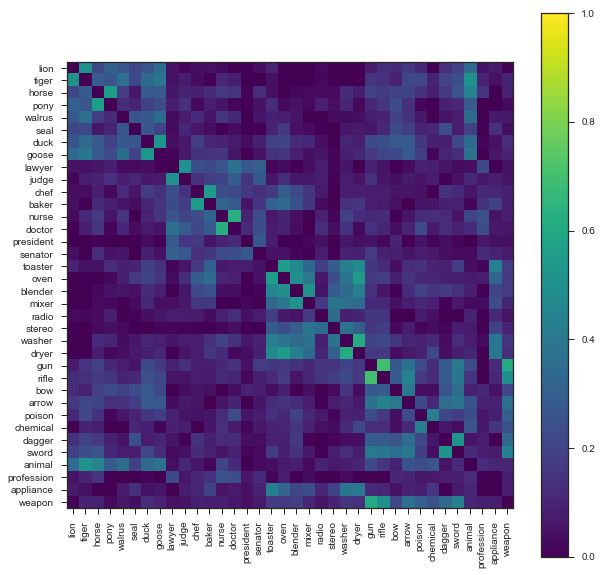

In [1106]:
goodmon_graph = SemanticGraph(word_dsm=goodmon_dsm, labels=all_words)
#goodmon_graph.adj[-4:, :] = 0
#goodmon_graph.adj[-4, 0:8] = .5
#goodmon_graph.adj[-3, 8:16] = .5
#goodmon_graph.adj[-2, 16:24] = .5
#goodmon_graph.adj[-1, 24:32] = .5
#goodmon_graph.adj[:, -4:] = 0
#goodmon_graph.adj[0:8, -4] = .5
#goodmon_graph.adj[8:16, -3] = .5
#goodmon_graph.adj[16:24, -2] = .5
#goodmon_graph.adj[24:32, -1] = .5
plot_labeled_matrix(goodmon_graph.adj, goodmon_graph.labels)

In [1093]:
goodmon_graph.adj[0].round(2)

array([ 0.  ,  0.51,  0.21,  0.31,  0.27,  0.22,  0.26,  0.35,  0.05,
        0.01,  0.04,  0.04,  0.03,  0.  ,  0.  ,  0.04,  0.1 ,  0.  ,
        0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.  ,  0.07,  0.13,  0.12,
        0.17,  0.11,  0.  ,  0.13,  0.2 ,  0.35,  0.05,  0.07,  0.01])

#### Study phase

<blockquote>In the study phase, participants saw category—exemplars pairs in the center of the computer screen at a rate of 5s each, and they were told to study each pair by relating the exemplar to its category name. The order for the pairs was block randomized, so that each block contained one exemplar from each category. The resulting eight blocks of six items (four items from the experimental categories and two items from the filler categories) ensured that exemplars from the categories were evenly distributed throughout the list. Within each block, the order was random except that (a) in the first block, filler items were presented first to minimize primacy effects; (b) in the last block, two fillers were presented last to minimize recency effects; (c) no two categories appeared in sequence more than once; and (d) exemplars within the same category were spaced so that there was an average of seven other items in between them. Also, the average distance between the Rp+ and the Rp- items for a given category was kept constant across the inter-set and intra-set conditions, and Rp+ and Rp- items within each category were distributed throughout the study list.</blockquote>

We are not going to do the fancy recency counterbalancing.

In [1094]:
def study(category, exemplar, graph, strength=0.1, debug=False):
    print("Studying (c) {0} to (e) {1}".format(category, exemplar))
    # Strengthen the weights to and from the exemplar word and the category word
    category_i = graph.labels.index(category)
    exemplar_i = graph.labels.index(exemplar)
    graph.adj[category_i, exemplar_i] += strength
    graph.adj[exemplar_i, category_i] += strength
    graph.adj = np.clip(graph.adj, a_min=0, a_max=1)
    
    # Activate both nodes
    graph.activate(category, debug=debug)
    graph.activate(exemplar, debug=debug)

In [1095]:
def cued_recall(cue, correct, graph):
    cue_i = graph.labels.index(cue)
    correct_i = graph.labels.index(correct)
    weight = graph.adj[cue_i, correct_i]
    success = np.random.uniform() < weight
    
    graph.activate(cue, debug=True)
    if success:
        graph.activate(correct, debug=True)
        
    print("Cued recall. Prompt: {0} Correct: {1} Weight: {2} Success: {3}".format(cue, correct, weight, success))

In [1096]:
def get_study_pairs(pairs, category):
    study_pairs = []
    for pair in pairs:
        study_pairs.append((category, pair[0]))
        study_pairs.append((category, pair[1]))
    return study_pairs

In [1097]:
study_pairs_animal = get_study_pairs(animal_pairs, 'animal')
study_pairs_profession = get_study_pairs(profession_pairs, 'profession')
study_pairs_appliance = get_study_pairs(appliance_pairs, 'appliance')
study_pairs_weapon = get_study_pairs(weapon_pairs, 'weapon')

study_pairs_all = study_pairs_animal + study_pairs_profession + study_pairs_appliance + study_pairs_weapon

In [1098]:
random.shuffle(study_pairs_all)

In [1099]:
for study_pair in study_pairs_all:
    study(study_pair[0], study_pair[1], goodmon_graph)
    #plot_labeled_matrix(goodmon_graph.adj, goodmon_graph.labels)
    #plt.show()

Studying (c) weapon to (e) arrow
Studying (c) appliance to (e) toaster
Studying (c) animal to (e) lion
Studying (c) appliance to (e) dryer
Studying (c) animal to (e) goose
Studying (c) animal to (e) walrus
Studying (c) profession to (e) judge
Studying (c) appliance to (e) blender
Studying (c) profession to (e) nurse
Studying (c) profession to (e) lawyer
Studying (c) weapon to (e) rifle
Studying (c) animal to (e) horse
Studying (c) weapon to (e) poison
Studying (c) profession to (e) doctor
Studying (c) weapon to (e) bow
Studying (c) weapon to (e) dagger
Studying (c) appliance to (e) washer
Studying (c) profession to (e) baker
Studying (c) weapon to (e) gun
Studying (c) profession to (e) chef
Studying (c) animal to (e) seal
Studying (c) weapon to (e) chemical
Studying (c) profession to (e) president
Studying (c) animal to (e) duck
Studying (c) weapon to (e) sword
Studying (c) animal to (e) tiger
Studying (c) appliance to (e) radio
Studying (c) appliance to (e) mixer
Studying (c) professi

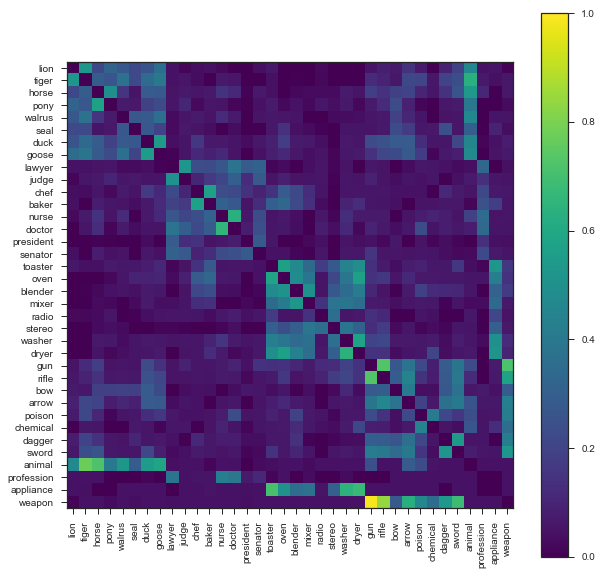

In [1100]:
plot_labeled_matrix(goodmon_graph.adj, goodmon_graph.labels)

#### Recall phase

<blockquote>In the retrieval practice phase, participants were told that their memory would be tested. They were told that on each test trial, they would see a category name and the first two letters of one member from that category on the screen, and they were asked to recall the studied category member that fit the letters and say the category and member out loud within 10 s. They were told that some of the words would be tested more than once and that they should recall them as they would any other. The presentation order of the category-plus-two-letter stem cues was pseudorandomized with the following constraints: (a) The first three and last three cues were filler items to acquaint participants with the task and to control for primacy and recency effects; (b) items were tested three times on an expanding schedule with an average of 3.5 trials between the first and second presentations and an average of 6.5 trials between the second and third presentations; (c) no two category members were retrieval practiced in succession; and (d) the use of filler items helped ensure that no two pairs appeared consecutively more than once.</blockquote>

Not doing the fancy counterbalancing/spacing.

There are two conditions: inter-set and intra-set. In the inter-set condition, one pair member is practiced and the other is not. In the intra-set condition, both members of two pairs are practiced, and the other two pairs are not praticed.

##### Inter-set practice

In [1101]:
# Practice the first word from each pair (and not the second)

inter_set_graph = copy.deepcopy(goodmon_graph)

inter_set_practice_pairs = []

for pair in animal_pairs:
    inter_set_practice_pairs.append(('animal', pair[0]))
for pair in profession_pairs:
    inter_set_practice_pairs.append(('profession', pair[0]))
for pair in appliance_pairs:
    inter_set_practice_pairs.append(('appliance', pair[0]))
for pair in weapon_pairs:
    inter_set_practice_pairs.append(('weapon', pair[0]))
    
inter_set_practice_pairs = inter_set_practice_pairs * 3
random.shuffle(inter_set_practice_pairs)

In [1102]:
for category, exemplar in inter_set_practice_pairs:
    cued_recall(cue=category, correct=exemplar, graph=goodmon_graph)

weapon at strength 1.0
[ 0.01  0.05  0.05  0.03  0.05  0.04  0.05  0.05  0.04  0.05  0.05  0.05
  0.05  0.05  0.04  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.99  0.84  0.28  0.63  0.47  0.35  0.53  0.69  0.05  0.05  0.05  0.  ]
Updating edge: weapon -> lion, + 0.0
Updating edge: weapon -> tiger, + -4.787526630393539e-06
tiger at strength 0.05000718128994559
[ 0.03  0.    0.    0.01  0.    0.01  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
Updating edge: tiger -> lion, + 0.0
Updating edge: tiger -> tiger, + 0.0
Updating edge: tiger -> horse, + 0.0
Updating edge: tiger -> pony, + 0.0
Updating edge: tiger -> walrus, + 0.0
Updating edge: tiger -> seal, + 0.0
Updating edge: tiger -> duck, + 0.0
Updating edge: tiger -> goose, + 0.0
Updating edge: tiger -> lawyer, + 0.0
Updating edge: tiger -> judge, + 0.0
Updating edge: tiger -> chef, + 0.0
Updat

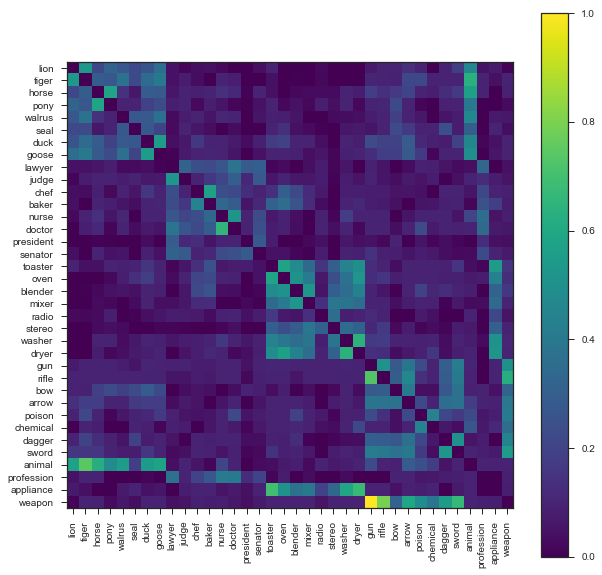

In [1043]:
plot_labeled_matrix(inter_set_graph.adj, inter_set_graph.labels)

##### Intra-set practice

In [1012]:
intra_set_graph = copy.deepcopy(goodmon_graph)
sorted_pairs = animal_pairs + profession_pairs + appliance_pairs + weapon_pairs
sorted_pairs

[('lion', 'tiger'),
 ('horse', 'pony'),
 ('walrus', 'seal'),
 ('duck', 'goose'),
 ('lawyer', 'judge'),
 ('chef', 'baker'),
 ('nurse', 'doctor'),
 ('president', 'senator'),
 ('toaster', 'oven'),
 ('blender', 'mixer'),
 ('radio', 'stereo'),
 ('washer', 'dryer'),
 ('gun', 'rifle'),
 ('bow', 'arrow'),
 ('poison', 'chemical'),
 ('dagger', 'sword')]

In [686]:
intra_set_practice_words = []
intra_set_unpracticed_words = []
for i, pair in enumerate(sorted_pairs):
    if i & 2 == 0:
        intra_set_practice_words.append(pair[0])
        intra_set_practice_words.append(pair[1])
    else:
        intra_set_unpracticed_words.append(pair[0])
        intra_set_unpracticed_words.append(pair[1])
    
intra_set_practice_words = intra_set_practice_words * 3

In [687]:
random.shuffle(intra_set_practice_words)

In [688]:
for word in intra_set_practice_words:
    intra_set_graph.activate(word)

gun at strength 1.0
rifle at strength 0.9
weapon at strength 0.1638
bow at strength 0.1522181519077262
arrow at strength 0.7303854926415148
poison at strength 0.15699725618892751
chemical at strength 0.21778514214933714
dagger at strength 0.21603119415771874
sword at strength 0.6626098967286094
gun at strength 1.0
rifle at strength 0.9
weapon at strength 0.149058
bow at strength 0.13851851823603084
arrow at strength 0.7407528398103829
poison at strength 0.14286750313192406
chemical at strength 0.1981844793558968
dagger at strength 0.19658838668352405
sword at strength 0.6699273420813968
chef at strength 1.0
baker at strength 0.48402434644392806
profession at strength 0.1638
lawyer at strength 0.6279682432638896
judge at strength 0.6104408075434725
nurse at strength 0.5566054756798045
doctor at strength 0.5541679193108177
president at strength 0.5645962513353042
senator at strength 0.7700691181682826
arrow at strength 1.0
gun at strength 0.10479889133519636
rifle at strength 0.9
weapon 

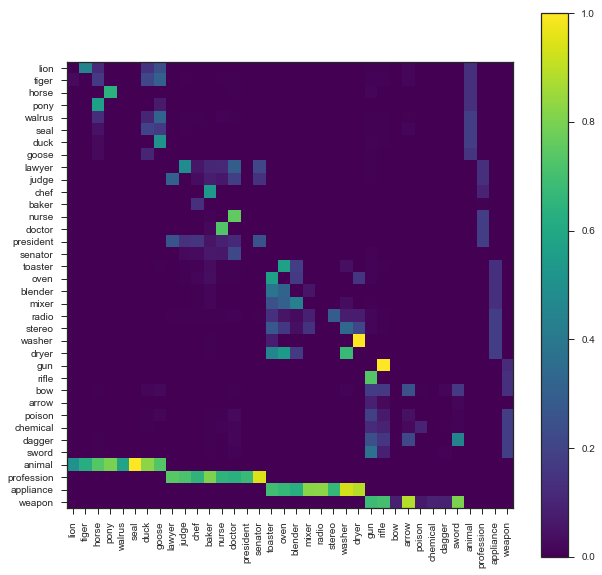

In [689]:
plot_labeled_matrix(intra_set_graph.adj, intra_set_graph.labels)

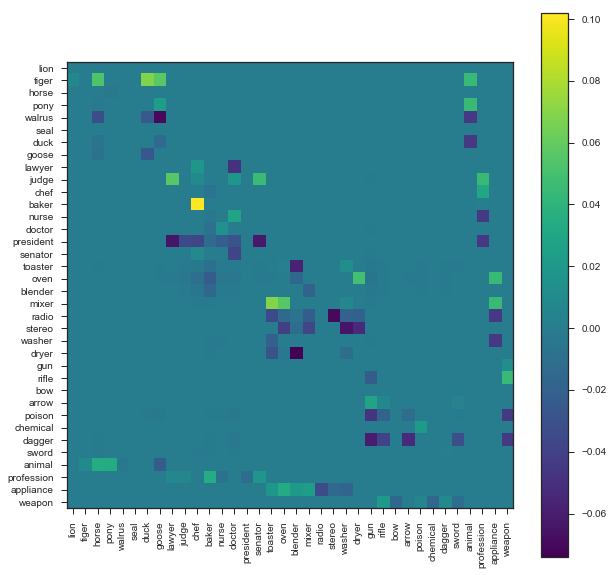

In [690]:
plot_labeled_matrix(inter_set_graph.adj - intra_set_graph.adj, inter_set_graph.labels)

In [637]:
intra_set_unpracticed_words

['walrus',
 'seal',
 'duck',
 'goose',
 'nurse',
 'doctor',
 'president',
 'senator',
 'radio',
 'stereo',
 'washer',
 'dryer',
 'poison',
 'chemical',
 'dagger',
 'sword']

## Getting reasonable word lists and distance matrices from the Google News corpus

### n clusters of hierarchically related words based on category seeds

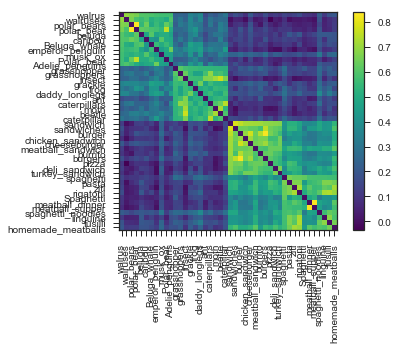

In [130]:
seeds = ['walrus', 'grasshopper', 'sandwich', 'spaghetti']
animals_food = []
for seed in seeds:
    animals_food += connected_word_list(seed, google_news, n_iterations=1)

animals_food_dsm = dist.squareform(semantic_dsm(word_list=animals_food, keyed_vectors=google_news))

animals_food_graph = SemanticGraph(word_dsm=animals_food_dsm, labels=animals_food)
plot_labeled_matrix(animals_food_graph.adj, animals_food_graph.labels)

### Randomly sample from the vocabulary

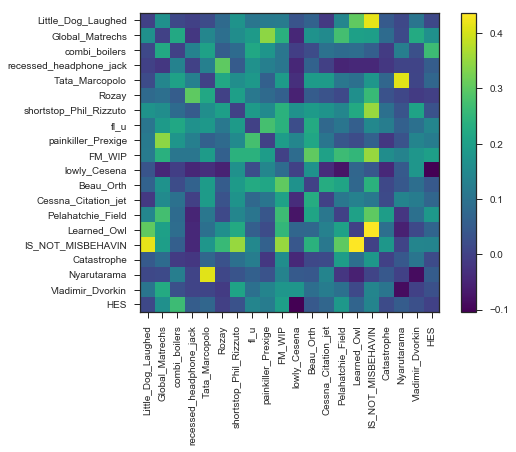

In [11]:
random_words = np.random.choice(list(google_news.vocab.keys()), 20)
random_words_dsm = dist.squareform(semantic_dsm(word_list=random_words, keyed_vectors=google_news))
random_words_graph = SemanticGraph(word_dsm=random_words_dsm, labels=random_words)

plot_labeled_matrix(random_words_graph.adj, random_words_graph.labels)

### Get vocabulary from a seed document

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

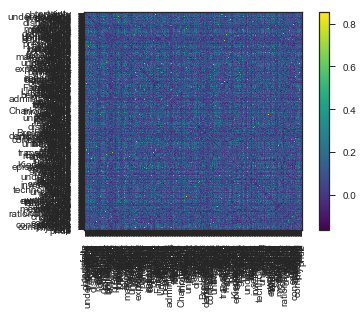

In [58]:
with open('../data/brooks.txt', 'r') as f:
    lines = f.readlines()
    
lines = [line.strip() for line in lines]
lines_string = ' '.join(lines)

# Strip punctuation
punctuation = string.punctuation + '“”—’'
punctuation = punctuation.replace('-', '')
remove_punct_map = dict.fromkeys(map(ord, punctuation))
lines_string = lines_string.translate(remove_punct_map)

# Remove stopwords
words = set(word_tokenize(lines_string))
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]

# Build a keyed vector dictionary, omitting words that are not in the corpus
brooks_dsm, brooks_labels = semantic_dsm_safe(words, google_news)
brooks_graph = SemanticGraph(word_dsm=dist.squareform(brooks_dsm), labels=brooks_labels)
plot_labeled_matrix(brooks_graph.adj, brooks_graph.labels)

In [59]:
words

['certainty',
 'falls',
 'objectively',
 'nation',
 'blind',
 'understanding',
 'courage',
 'everything',
 'provides',
 'conflict',
 'political',
 'may',
 'fired',
 'live',
 'living',
 'dishonesty',
 'much',
 'original',
 'defined',
 'escape',
 'opposed',
 'In',
 'evidence',
 'mongering',
 'Bannon',
 'assertive',
 'questions',
 'big',
 'pain',
 'moment',
 'seems',
 'depressing',
 'rest',
 'Muslim',
 'competing',
 'anger',
 'security',
 'unnamable',
 'boundaries',
 'whites',
 'Higgins',
 'adjustment',
 'tough',
 'due',
 'deal',
 'Donald',
 'trust',
 'build',
 'presidency',
 'Progress',
 'whole',
 'war',
 'Many',
 'diversity',
 'anything',
 'incuriosity',
 'possess',
 'foreigners',
 'stand',
 'Americas',
 'leads',
 'Were',
 'system',
 'Over',
 'going',
 'fanaticism',
 'next',
 'appreciate',
 'malevolently',
 'within',
 'loons',
 'written',
 'controlled',
 'vicious',
 'learning',
 'Back',
 'crushing',
 'understood',
 'creativity',
 'anxiety',
 'inevitably',
 'But',
 'take',
 'give',
 'nec

## Spectral clustering (or at least re-ordering)

(This maybe doesn't work right now?)

In [236]:
def discretize(similarity_matrix, threshold=.5):
    zeros = np.zeros_like(similarity_matrix)
    zeros[similarity_matrix > threshold] = 1
    return zeros

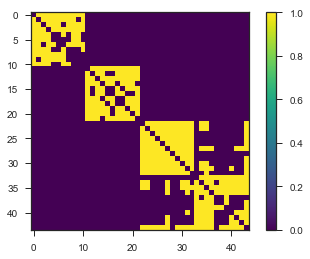

In [237]:
plot_labeled_matrix(discretize(animals_food_graph.adj))

In [238]:
def degree_continuous(similarity_matrix, edge_type='in', discrete=False):
    assert edge_type in ['in', 'out']
    if edge_type is 'in':
        axis = 0
    if edge_type is 'out':
        axis = 1
    if discrete:
        similarity_matrix = discretize(similarity_matrix)
    diag = np.sum(similarity_matrix, axis=0)
    degree = np.zeros_like(similarity_matrix)
    np.fill_diagonal(degree, diag)
    return degree

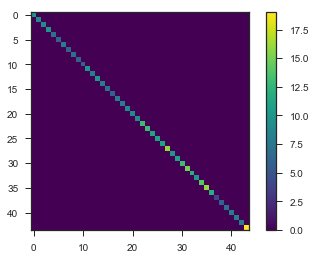

In [239]:
plot_labeled_matrix(degree_continuous(animals_food_graph.adj, discrete=True))

In [240]:
D = degree_continuous(animals_food_graph.adj, discrete=True)
W = animals_food_graph.adj
L = D - W

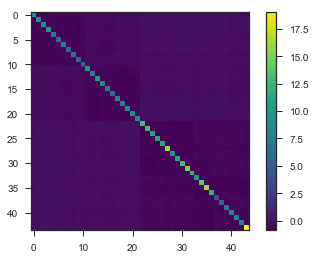

In [241]:
plot_labeled_matrix(L)

In [242]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [244]:
# Get the eigenvector associated with the 2nd smallest eigenvalue
index_of_second_smallest_evalue = sorted(enumerate(eigenvalues), key=lambda i:i[1])[1][0]
second_smallest_evector = eigenvectors[index_of_second_smallest_evalue]

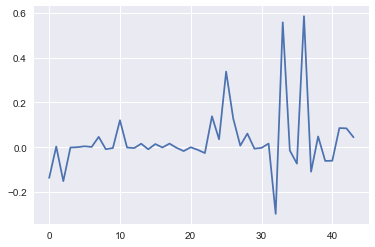

In [245]:
plt.plot(second_smallest_evector)

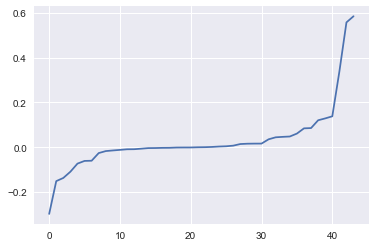

In [246]:
plt.plot(sorted(second_smallest_evector))

In [247]:
cluster_order = np.array(sorted(enumerate(second_smallest_evector), key=lambda i:i[1]), dtype=np.int)[:, 0]

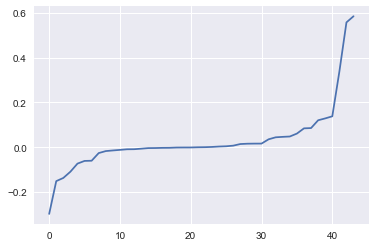

In [248]:
plt.plot(second_smallest_evector[cluster_order])

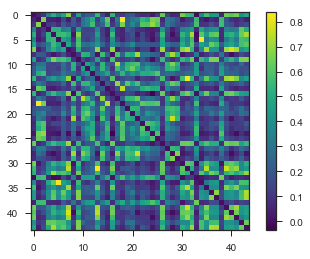

In [249]:
r = animals_food_graph.adj[cluster_order,:]
r = r[:,cluster_order]
plot_labeled_matrix(r)

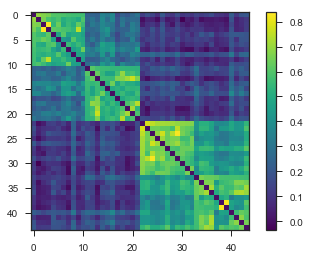

In [232]:
plot_labeled_matrix(animals_food_graph.adj)

In [224]:
from scipy.io import savemat

In [225]:
savemat('animals_food.mat', {'adj': animals_food_graph.adj, 'labels': animals_food_graph.labels})

## Saving and loading word vectors

In [358]:
import json

In [362]:
kv = {word: google_news.word_vec(word).tolist() for word in animals_food}

In [363]:
with open('animals_food.json', 'w') as f:
    json.dump(kv, f)

In [366]:
with open('animals_food.json', 'r') as f:
    kv_loaded = json.load(f)

In [367]:
kv_loaded['walrus']

[-0.047607421875,
 0.1591796875,
 -0.392578125,
 0.057373046875,
 -0.027099609375,
 0.021240234375,
 -0.048583984375,
 -0.0103759765625,
 0.1474609375,
 -0.01336669921875,
 0.1708984375,
 -0.177734375,
 -0.3125,
 -0.005584716796875,
 -0.396484375,
 -0.251953125,
 -0.466796875,
 -0.0634765625,
 -0.20703125,
 -0.28515625,
 -0.3203125,
 -0.171875,
 0.06640625,
 -0.09228515625,
 0.09765625,
 -0.5703125,
 -0.04150390625,
 0.0120849609375,
 0.2373046875,
 -0.07275390625,
 -0.08740234375,
 0.458984375,
 -0.1064453125,
 -0.07421875,
 0.1494140625,
 -0.00946044921875,
 0.16796875,
 0.359375,
 0.26171875,
 -0.1650390625,
 -0.1787109375,
 -0.06494140625,
 0.046630859375,
 0.25390625,
 0.11279296875,
 -0.2470703125,
 -0.0634765625,
 0.001983642578125,
 0.478515625,
 0.0712890625,
 -0.2333984375,
 -0.12890625,
 -0.14453125,
 -0.1865234375,
 0.13671875,
 -0.03173828125,
 -0.11572265625,
 -0.3125,
 0.1337890625,
 -0.34375,
 -0.220703125,
 0.25390625,
 0.1845703125,
 -0.5,
 0.46875,
 -0.474609375,
 0.